<a href="https://colab.research.google.com/github/lee-seong-wook/Adversarial_Attack/blob/main/Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

예측된 레이블 번호: 735
레이블 이름: poncho


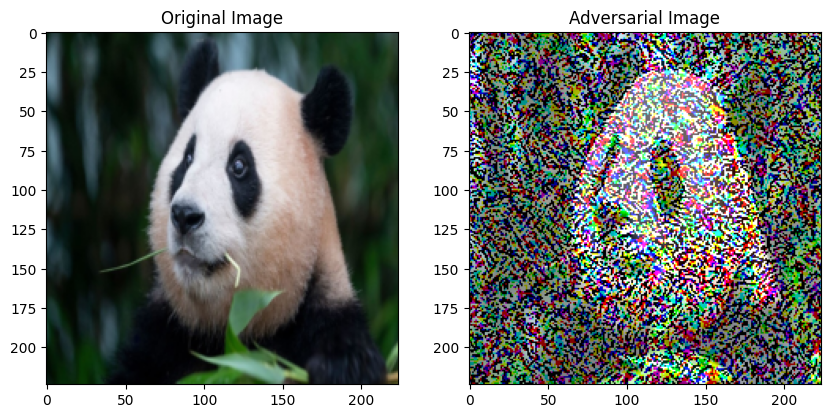

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import json
import requests

# 이 파일은 ImageNet의 클래스 인덱스와 이름을 매핑합니다.
imagenet_class_index_url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
imagenet_labels = json.loads(requests.get(imagenet_class_index_url).text)

model = models.resnet18(pretrained=True)  # 모델은 사용자 지정에 따라 사용 가능
model.eval()

image_path = '/content/17064911312214_20240123502746.jpg'  # 여기서 이미지 경로를 지정
img = Image.open(image_path)

# 이미지를 텐서로 변환하고 모델에 맞게 크기 조절
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
img_tensor = transform(img).unsqueeze(0)  # 배치 차원을 추가

def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

img_tensor.requires_grad_(True)

# 이미지를 모델에 통과시킴
output = model(img_tensor)

# 오차값 구하기 (레이블 388은 팬더)
target_label = 388  # 목표 레이블 (예: 팬더)
loss = F.nll_loss(F.log_softmax(output, dim=1), torch.tensor([target_label]))

# 기울기값 구하기
model.zero_grad()
loss.backward()

# 이미지의 기울기값을 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.5 # epsilon의 값으로 정도 설정 가능 ex)0.01 = 1%
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)


# 예측 결과 확인
perturbed_prediction = output.max(1, keepdim=True)[1]
perturbed_prediction_idx = perturbed_prediction.item()

# ImageNet 클래스 인덱스와 이름 매핑
# 예측 결과 출력
perturbed_prediction_name = imagenet_labels[perturbed_prediction_idx]
print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.permute(1, 2, 0).numpy()

# 원본 이미지와 적대적 이미지를 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# 원본 이미지 시각화
original_img_view = img_tensor.squeeze(0).detach()
original_img_view = original_img_view.permute(1, 2, 0).numpy()
ax1.imshow(original_img_view)
ax1.set_title("Original Image")

# 적대적 이미지 시각화
ax2.imshow(perturbed_data_view)
ax2.set_title("Adversarial Image")

plt.show()
